# Clustering based on BYTES, PACKETS, DURATION

## Preparing a dataset

Load the dataset.

In [2]:
from cesnet_datazoo.datasets import CESNET_QUIC22, CESNET_TLS22

dataset = CESNET_QUIC22(data_root="data/CESNET_QUIC22/", size="XS", silent=True)

Prepare the dataset with config and check its columns.

In [3]:
from cesnet_datazoo.config import DatasetConfig

dataset_config = DatasetConfig(
    dataset=dataset,
    train_period_name="W-2022-44",
    train_size=100_000,
    use_packet_histograms=True,
)
dataset.set_dataset_config_and_initialize(dataset_config)

data_df = dataset.get_train_df()
data_df.columns

Index(['PPI', 'BYTES', 'BYTES_REV', 'PACKETS', 'PACKETS_REV', 'DURATION',
       'PPI_LEN', 'PPI_ROUNDTRIPS', 'PPI_DURATION', 'FLOW_ENDREASON_IDLE',
       'FLOW_ENDREASON_ACTIVE', 'FLOW_ENDREASON_OTHER', 'PSIZE_BIN1',
       'PSIZE_BIN2', 'PSIZE_BIN3', 'PSIZE_BIN4', 'PSIZE_BIN5', 'PSIZE_BIN6',
       'PSIZE_BIN7', 'PSIZE_BIN8', 'PSIZE_BIN1_REV', 'PSIZE_BIN2_REV',
       'PSIZE_BIN3_REV', 'PSIZE_BIN4_REV', 'PSIZE_BIN5_REV', 'PSIZE_BIN6_REV',
       'PSIZE_BIN7_REV', 'PSIZE_BIN8_REV', 'IPT_BIN1', 'IPT_BIN2', 'IPT_BIN3',
       'IPT_BIN4', 'IPT_BIN5', 'IPT_BIN6', 'IPT_BIN7', 'IPT_BIN8',
       'IPT_BIN1_REV', 'IPT_BIN2_REV', 'IPT_BIN3_REV', 'IPT_BIN4_REV',
       'IPT_BIN5_REV', 'IPT_BIN6_REV', 'IPT_BIN7_REV', 'IPT_BIN8_REV', 'APP'],
      dtype='object')

Add imports.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Prepare the dataset dataframe.
Convert APP column to APP_NAME.

In [5]:
data_df["APP_NAME"] = data_df["APP"].apply(lambda x: dataset._tables_app_enum.get(x, "Unknown"))

data_df["APP_NAME"].value_counts()

APP_NAME
bongacams                6830
cloudflare-cdnjs         6355
alza-identity            6323
flightradar24            6110
playradio                5551
                         ... 
google-authentication       9
instagram                   9
ebay-kleinanzeigen          9
google-autofill             8
uber                        7
Name: count, Length: 101, dtype: int64

## Feature extraction

Create new features.

In [6]:
data_df["BYTES_PER_PACKET"] = data_df["BYTES"] / data_df["PACKETS"]
data_df["BYTES_PER_PACKET_REV"] = data_df["BYTES_REV"] / data_df["PACKETS_REV"]

Get only the columns that are needed for clustering.

In [7]:
features_to_extract = ["PACKETS", "PACKETS_REV", "BYTES", "BYTES_REV", "DURATION",
                       "PPI_LEN", "PPI_ROUNDTRIPS", "PPI_DURATION",
                       "BYTES_PER_PACKET", "BYTES_PER_PACKET_REV"]

features_array = data_df[features_to_extract].to_numpy()
app_array = data_df[["APP"]].to_numpy().reshape(-1)

## Preprocessing

Standardize the features.

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

preprocessing_pipeline = Pipeline([
    ('scaler', StandardScaler()),
])

preprocessed_array = preprocessing_pipeline.fit_transform(features_array)

## Application choice

## Functions

In [9]:
import numpy as np
from itertools import combinations
from numpy.linalg import inv, det

def bhattacharyya_distance(mean1, cov1, mean2, cov2):
    cov_avg = (cov1 + cov2) / 2
    mean_diff = mean1 - mean2
    term1 = 0.125 * np.dot(np.dot(mean_diff.T, inv(cov_avg)), mean_diff)
    term2 = 0.5 * np.log(det(cov_avg) / np.sqrt(det(cov1) * det(cov2)))
    return term1 + term2

def find_most_different_classes_statistical(X, y, num_classes=5):
    unique_classes = np.unique(y)
    class_stats = {}
    for cls in unique_classes:
        X_cls = X[y == cls]
        mean = X_cls.mean(axis=0)
        cov = np.cov(X_cls, rowvar=False) + 1e-6 * np.eye(X_cls.shape[1])  # small regularization
        class_stats[cls] = (mean, cov)

    classes = list(class_stats.keys())
    n = len(classes)

    # Build distance matrix
    distance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            mean1, cov1 = class_stats[classes[i]]
            mean2, cov2 = class_stats[classes[j]]
            dist = bhattacharyya_distance(mean1, cov1, mean2, cov2)
            distance_matrix[i, j] = dist
            distance_matrix[j, i] = dist

    # Step 1: pick the pair with maximum distance
    i, j = np.unravel_index(np.argmax(distance_matrix), distance_matrix.shape)
    selected_indices = [i, j]
    remaining_indices = set(range(n)) - set(selected_indices)

    # Step 2: iteratively add the class farthest from current set
    while len(selected_indices) < num_classes and remaining_indices:
        best_candidate = None
        best_min_dist = -1
        for idx in remaining_indices:
            min_dist = min(distance_matrix[idx, sel] for sel in selected_indices)
            if min_dist > best_min_dist:
                best_min_dist = min_dist
                best_candidate = idx
        selected_indices.append(best_candidate)
        remaining_indices.remove(best_candidate)

    selected_classes = [classes[idx] for idx in selected_indices]

    print(f"Selected classes (most statistically different): {selected_classes}")
    return selected_classes


In [10]:
import numpy as np
from itertools import combinations
from numpy.linalg import inv

def lda_separation_score(X1, X2):
    # Means
    mean1 = X1.mean(axis=0)
    mean2 = X2.mean(axis=0)

    # Covariances
    cov1 = np.cov(X1, rowvar=False) + 1e-6 * np.eye(X1.shape[1])
    cov2 = np.cov(X2, rowvar=False) + 1e-6 * np.eye(X2.shape[1])

    # Within-class scatter
    S_W = cov1 + cov2

    # Between-class scatter
    mean_diff = (mean1 - mean2).reshape(-1, 1)
    S_B = np.dot(mean_diff, mean_diff.T)

    # LDA score: trace(S_W^-1 S_B)
    score = np.trace(np.dot(inv(S_W), S_B))
    return score

def find_most_different_classes_lda(X, y, num_classes=5):
    unique_classes = np.unique(y)
    class_data = {cls: X[y == cls] for cls in unique_classes}

    classes = list(class_data.keys())
    n = len(classes)

    # Build separation score matrix
    score_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            score = lda_separation_score(class_data[classes[i]], class_data[classes[j]])
            score_matrix[i, j] = score
            score_matrix[j, i] = score

    # Step 1: pick the pair with maximum LDA separation score
    i, j = np.unravel_index(np.argmax(score_matrix), score_matrix.shape)
    selected_indices = [i, j]
    remaining_indices = set(range(n)) - set(selected_indices)

    # Step 2: iteratively add the class that maximizes minimum separation to current set
    while len(selected_indices) < num_classes and remaining_indices:
        best_candidate = None
        best_min_score = -np.inf
        for idx in remaining_indices:
            min_score = min(score_matrix[idx, sel] for sel in selected_indices)
            if min_score > best_min_score:
                best_min_score = min_score
                best_candidate = idx
        selected_indices.append(best_candidate)
        remaining_indices.remove(best_candidate)

    selected_classes = [classes[idx] for idx in selected_indices]

    print(f"Selected classes (most LDA separable): {selected_classes}")
    return selected_classes


## Choice

In [11]:
# top 1
# top_apps = find_most_different_classes_statistical(preprocessed_array, app_array, num_classes=5)

# top 2
top_apps = find_most_different_classes_lda(preprocessed_array, app_array, 5)

top_apps

Selected classes (most LDA separable): [40, 81, 34, 15, 83]


[40, 81, 34, 15, 83]

In [12]:
only_top_apps_array = np.isin(app_array, top_apps)

filtered_app_array = app_array[only_top_apps_array]
filtered_preprocessed_array = preprocessed_array[only_top_apps_array]

In [54]:
dataset._tables_app_enum.get(83)

'kiwi-com'

In [14]:
np.unique(filtered_app_array, return_counts=True)

(array([15, 34, 40, 81, 83]), array([200,   9,  39,  45,  18]))

## KMeans

### Clustering

Cluster the data using KMeans.

In [15]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=np.unique(filtered_app_array).shape[0], random_state=42)
kmeans.fit(filtered_preprocessed_array)

KMeans(n_clusters=5, random_state=42)

Count of clusters.

In [16]:
np.unique(kmeans.labels_, return_counts=True)

(array([0, 1, 2, 3, 4], dtype=int32), array([217,  46,  46,   1,   1]))

In [17]:
from sklearn.cluster import KMeans

NUMBER_OF_MULTIPLIERS = 10

number_of_clusters = np.unique(filtered_app_array).shape[0]

kmeans_partitions = []

for cluster_multiplier in range(1, NUMBER_OF_MULTIPLIERS+1):
    kmeans_instance = KMeans(n_clusters=number_of_clusters * cluster_multiplier, random_state=42)
    kmeans_instance.fit(filtered_preprocessed_array)
    kmeans_partitions.append(kmeans_instance.labels_)

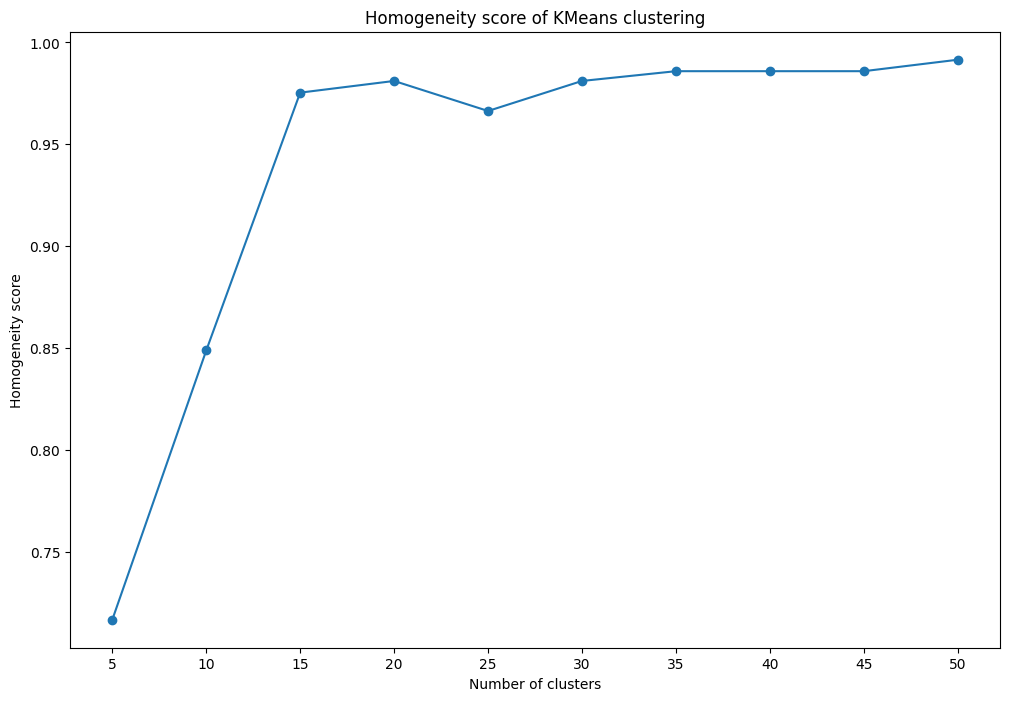

In [18]:
from sklearn.metrics.cluster import homogeneity_score

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(range(number_of_clusters, number_of_clusters * (NUMBER_OF_MULTIPLIERS + 1), number_of_clusters), [homogeneity_score(filtered_app_array, kmeans) for kmeans in kmeans_partitions], marker='o')
ax.set_title("Homogeneity score of KMeans clustering")
ax.set_xlabel("Number of clusters")
ax.set_ylabel("Homogeneity score")
ax.set_xticks(range(number_of_clusters, number_of_clusters * (NUMBER_OF_MULTIPLIERS + 1), number_of_clusters))
plt.show()
# fig.savefig("kmeans_homogeneity.png", bbox_inches='tight')

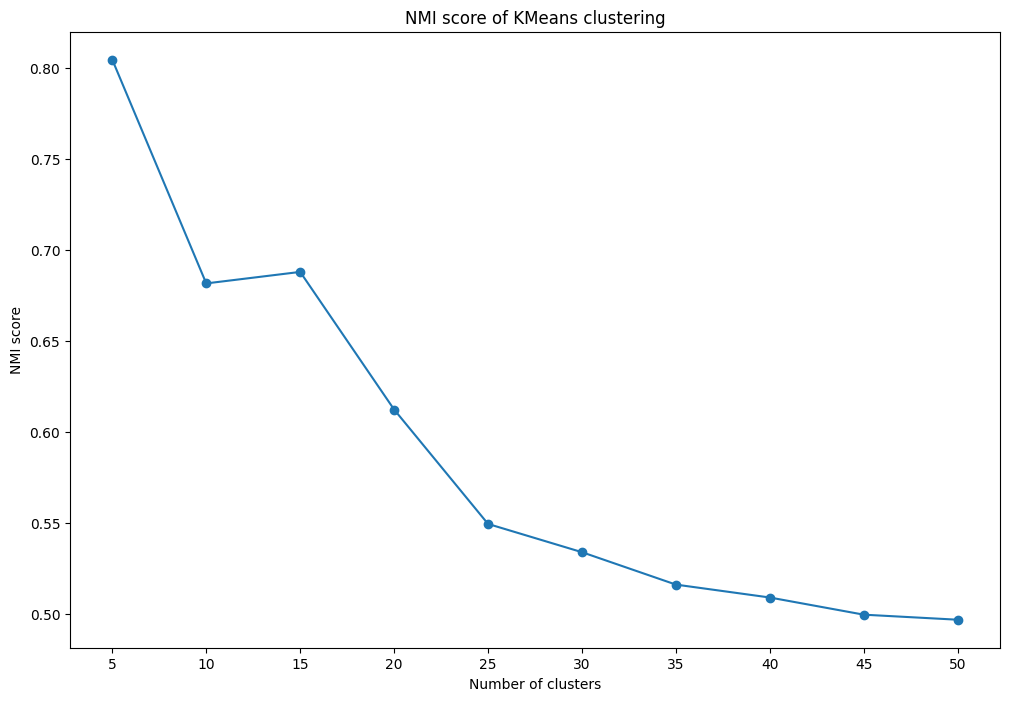

In [19]:
from sklearn.metrics.cluster import normalized_mutual_info_score

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(range(number_of_clusters, number_of_clusters * (NUMBER_OF_MULTIPLIERS + 1), number_of_clusters), [normalized_mutual_info_score(filtered_app_array, kmeans) for kmeans in kmeans_partitions], marker='o')
ax.set_title("NMI score of KMeans clustering")
ax.set_xlabel("Number of clusters")
ax.set_ylabel("NMI score")
ax.set_xticks(range(number_of_clusters, number_of_clusters * (NUMBER_OF_MULTIPLIERS + 1), number_of_clusters))
plt.show()
# fig.savefig("kmeans_nmi.png", bbox_inches='tight')

### Evaluation

In [34]:
from sklearn.metrics.cluster import homogeneity_score

# homogeneity_score(filtered_app_array, kmeans.labels_)
homogeneity_score(filtered_app_array, kmeans_partitions[2])

0.9753852646317026

In [21]:
from sklearn.metrics.cluster import normalized_mutual_info_score

normalized_mutual_info_score(filtered_app_array, kmeans.labels_)

0.8044026079893625

In [37]:
from sklearn.metrics.cluster import contingency_matrix

matrix = contingency_matrix(filtered_app_array, kmeans_partitions[0])

np.savetxt("mydata.csv", matrix, delimiter=' & ', fmt="%d", newline=' \\\\\n')
matrix

array([[199,   0,   0,   1,   0],
       [  2,   7,   0,   0,   0],
       [  0,  39,   0,   0,   0],
       [  0,   0,  44,   0,   1],
       [ 16,   0,   2,   0,   0]])

### Visualization

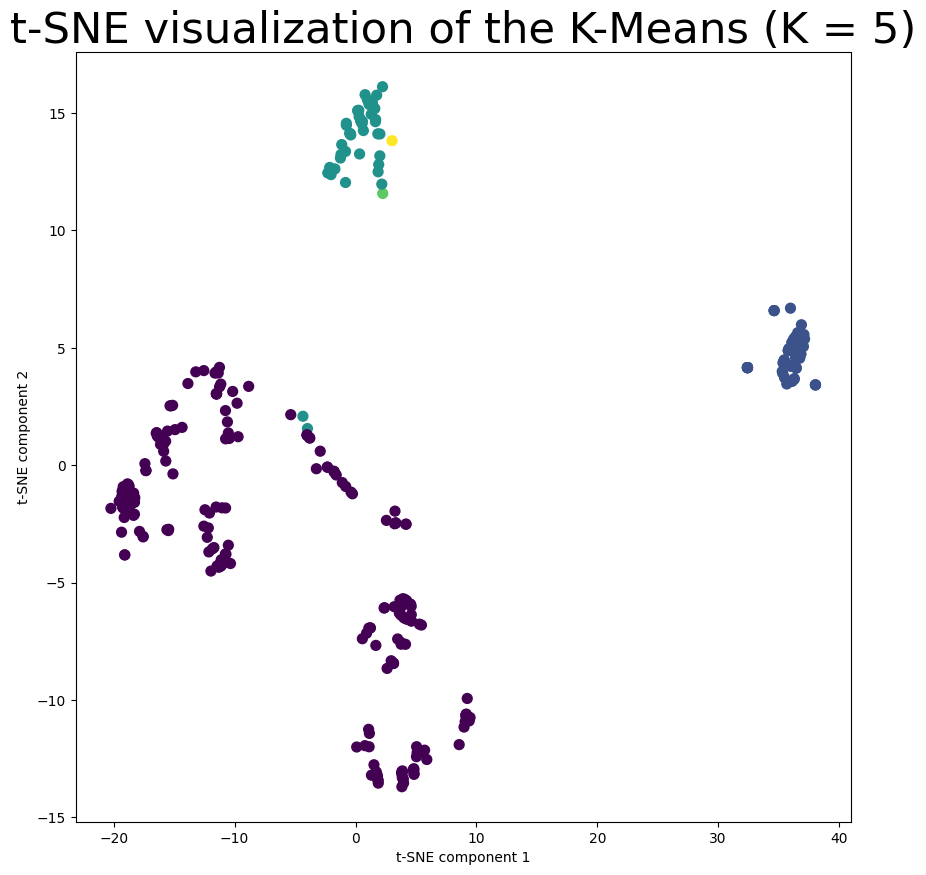

In [24]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_array = tsne.fit_transform(filtered_preprocessed_array)

fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 26})
scatter = ax.scatter(tsne_array[:, 0], tsne_array[:, 1], c=kmeans_partitions[0], cmap='viridis', s=50)
ax.set_title("t-SNE visualization of the K-Means (K = 5)")
ax.set_xlabel("t-SNE component 1")
ax.set_ylabel("t-SNE component 2")
plt.show()
fig.savefig("kmeans_5clusters.png", bbox_inches='tight')

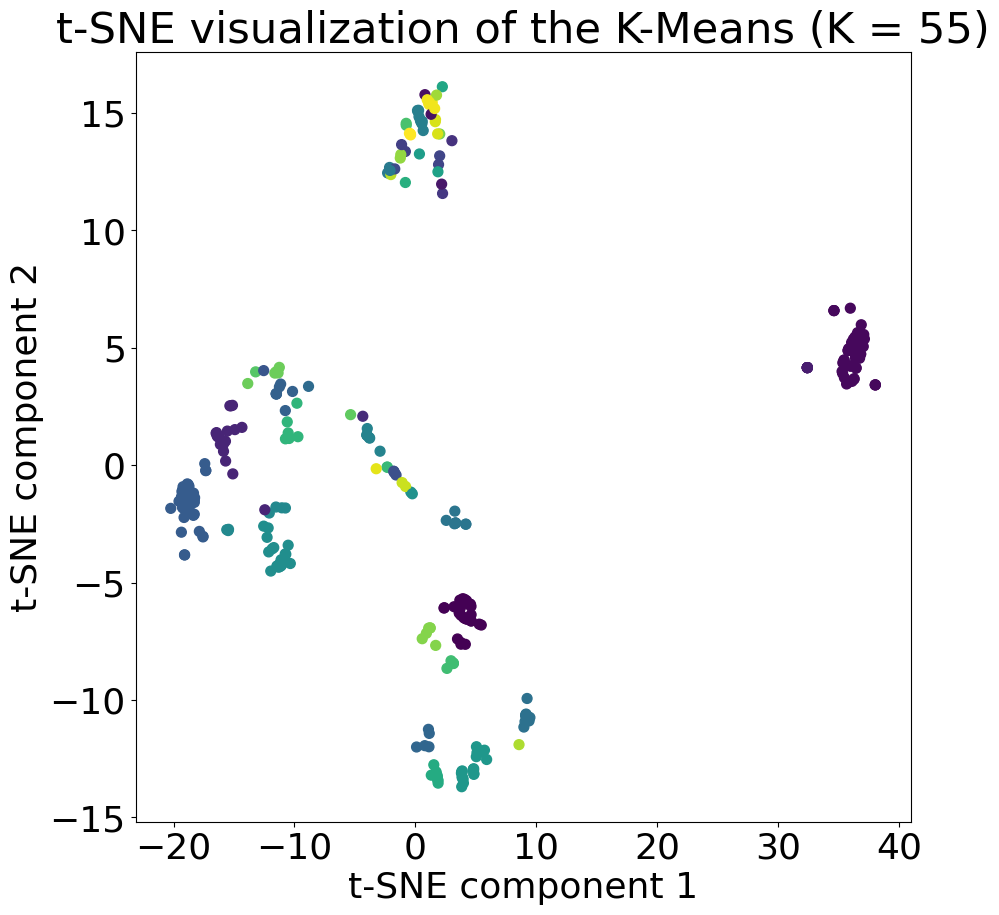

In [25]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_array = tsne.fit_transform(filtered_preprocessed_array)

fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 26})
scatter = ax.scatter(tsne_array[:, 0], tsne_array[:, 1], c=kmeans_partitions[-1], cmap='viridis', s=50)
ax.set_title("t-SNE visualization of the K-Means (K = 55)")
ax.set_xlabel("t-SNE component 1")
ax.set_ylabel("t-SNE component 2")
plt.show()
fig.savefig("kmeans_55clusters.png", bbox_inches='tight')

## DBSCAN

### Preparation

Let's start with elbow method to find the optimal number of clusters.

In [26]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

# If your data has more than 2 dimensions, choose MinPts = 2*dim, where dim= the dimensions of your data set (Sander et al., 1998).
neighbors = NearestNeighbors(n_neighbors=16).fit(filtered_preprocessed_array)
distances, _ = neighbors.kneighbors(filtered_preprocessed_array)

(60.0, 100.0, 0.0, 1.5)

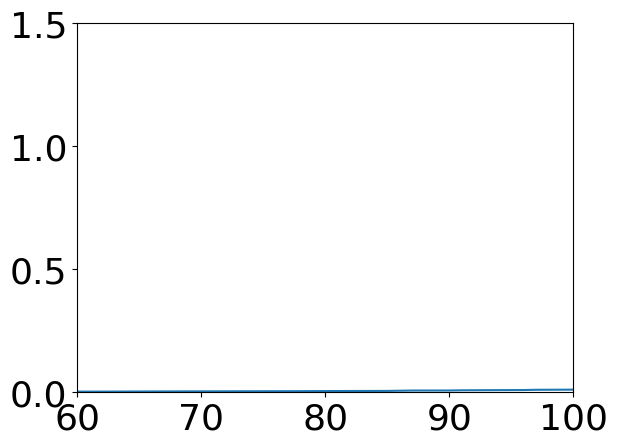

In [27]:
distances = np.sort(distances, axis=0)
plt.plot(distances[:,1])
plt.axis([60, 100, 0, 1.5])

### Clustering

DBSCAN clustering.

In [28]:
from sklearn.cluster import DBSCAN

# dbscan = DBSCAN(eps=1, min_samples=7).fit(filtered_preprocessed_array)

In [29]:
# np.unique(dbscan.labels_, return_counts=True)

### Evaluation

In [30]:
homogeneity_score(filtered_app_array, dbscan.labels_)

NameError: name 'dbscan' is not defined

In [31]:
normalized_mutual_info_score(filtered_app_array, dbscan.labels_)

0.8613187481906424

# HDBSCAN

In [40]:
from sklearn.cluster import HDBSCAN

hdbscan = HDBSCAN(min_samples=7).fit(filtered_preprocessed_array)

In [50]:
len(hdbscan.labels_)

311

In [42]:
np.unique(hdbscan.labels_, return_counts=True)

(array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 array([71, 39,  7, 31, 15, 16, 12, 38, 10,  9,  7, 19, 24, 13]))

In [43]:
contingency_matrix(filtered_app_array, hdbscan.labels_)

array([[52,  0,  0,  0,  0, 16, 12, 38, 10,  9,  7, 19, 24, 13],
       [ 1,  0,  7,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 39,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [14,  0,  0, 31,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 4,  0,  0,  0, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [45]:
hdbscan_cleared_labels = hdbscan.labels_[hdbscan.labels_ != -1]
cleared_app_array = filtered_app_array[hdbscan.labels_ != -1]

In [46]:
contingency_matrix(cleared_app_array, hdbscan_cleared_labels)

array([[ 0,  0,  0,  0, 16, 12, 38, 10,  9,  7, 19, 24, 13],
       [ 0,  7,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [39,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 31,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [47]:
len(filtered_app_array[filtered_app_array == 23])

0

In [48]:
homogeneity_score(filtered_app_array, hdbscan.labels_), homogeneity_score(cleared_app_array, hdbscan_cleared_labels)

(0.828043257602576, 0.9865349612435983)

In [49]:
normalized_mutual_info_score(filtered_app_array, hdbscan.labels_), normalized_mutual_info_score(cleared_app_array, hdbscan_cleared_labels)

(0.5186213176336605, 0.633181410870614)

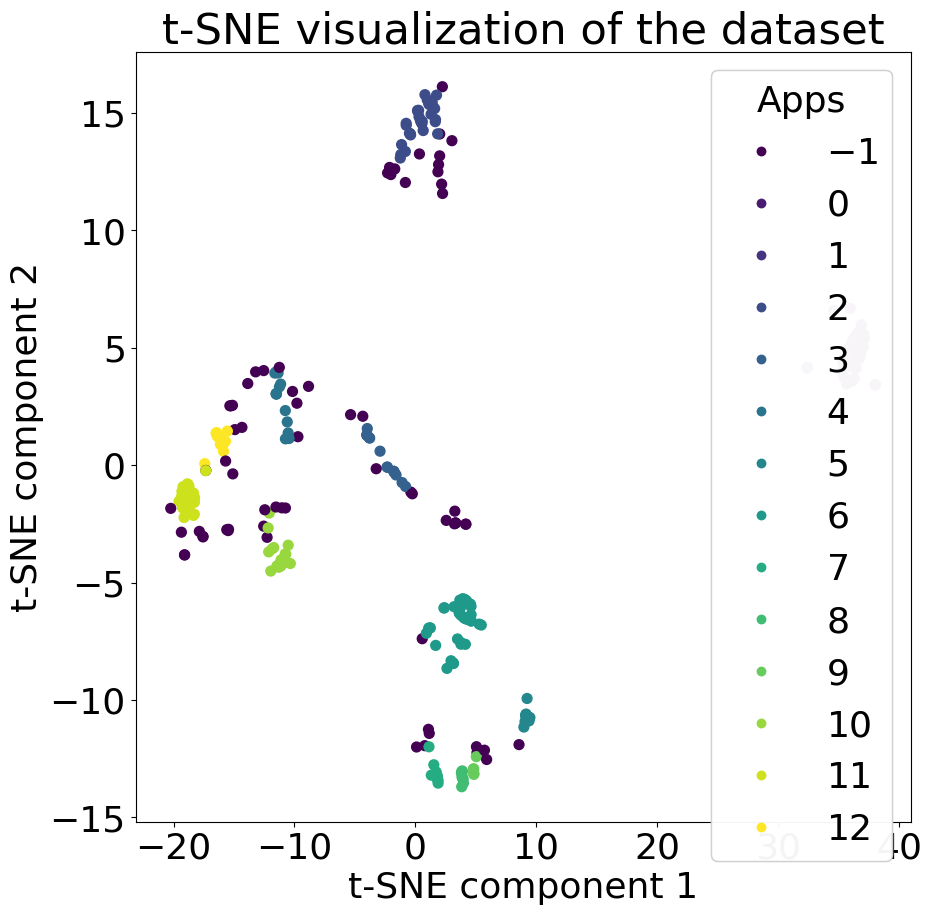

In [119]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_array = tsne.fit_transform(filtered_preprocessed_array)

fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 26})
scatter = ax.scatter(tsne_array[:, 0], tsne_array[:, 1], c=hdbscan.labels_, cmap='viridis', s=50)
# scatter = ax.scatter(tsne_array[:, 0], tsne_array[:, 1], c=kmeans.labels_, cmap='viridis', s=60)
legend = ax.legend(*scatter.legend_elements(), title="Apps")
ax.set_title("t-SNE visualization of the dataset")
ax.set_xlabel("t-SNE component 1")
ax.set_ylabel("t-SNE component 2")
ax.add_artist(legend)
plt.show()
# fig.savefig("truelabels.png", bbox_inches='tight')

## Visualization

In [122]:
# map labels using labelencoder
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
filtered_encoded_app_array = label_encoder.fit_transform(filtered_app_array)

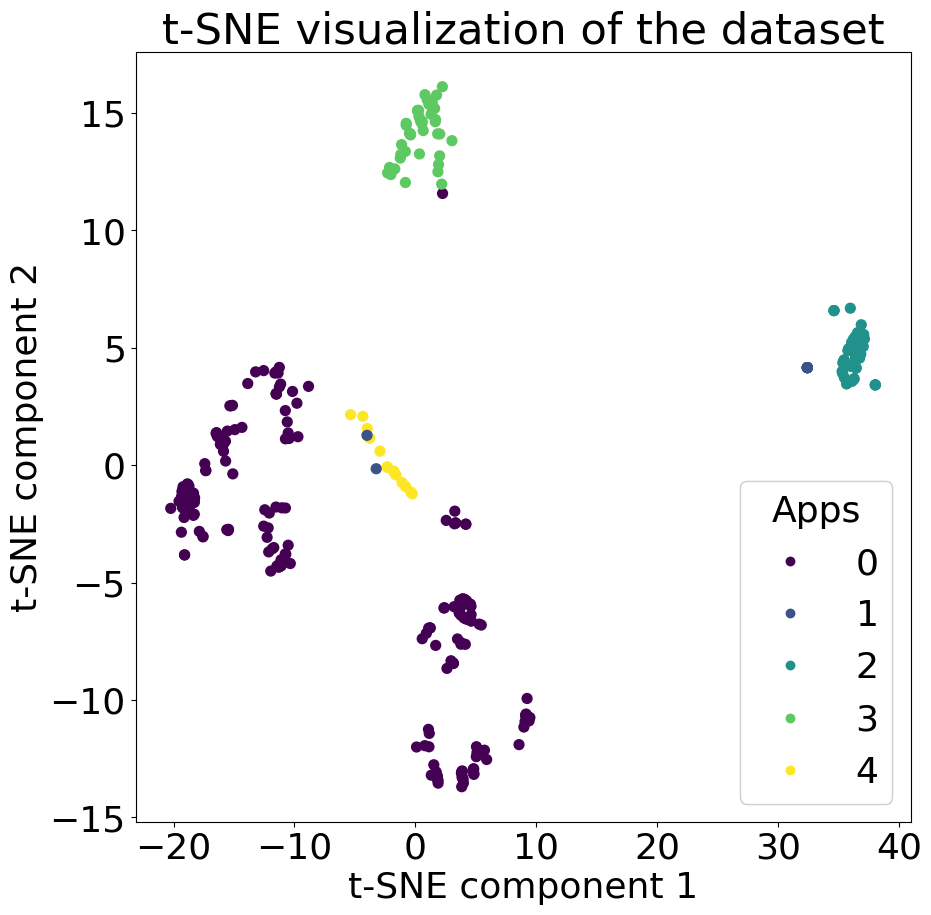

In [123]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
tsne_array = tsne.fit_transform(filtered_preprocessed_array)

fig, ax = plt.subplots(figsize=(10, 10))
plt.rcParams.update({'font.size': 26})
scatter = ax.scatter(tsne_array[:, 0], tsne_array[:, 1], c=filtered_encoded_app_array, cmap='viridis', s=50)
# scatter = ax.scatter(tsne_array[:, 0], tsne_array[:, 1], c=kmeans.labels_, cmap='viridis', s=60)
legend = ax.legend(*scatter.legend_elements(), title="Apps")
ax.set_title("t-SNE visualization of the dataset")
ax.set_xlabel("t-SNE component 1")
ax.set_ylabel("t-SNE component 2")
ax.add_artist(legend)
plt.show()
fig.savefig("truelabels.png", bbox_inches='tight')